In [105]:

import vtk
import os
import numpy as np
import itertools
import math, random
import data_process_ml
random.seed = 42
import copy

import torch
from torch.utils.data import Dataset, DataLoader
from torch.utils.data import random_split
from torchvision import transforms, utils

import scipy.spatial.distance
# import plotly.graph_objects as go
# import plotly.express as px
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix



In [106]:
import open3d as o3d
def reduce_mesh(target_mesh, reference_mesh):
    # Find common vertices between the two meshes
    output_mesh = copy.deepcopy(target_mesh)
    target_vertices = set(tuple(vertex) for vertex in np.asarray(target_mesh.vertices))
    target_vertices_list = [tuple(vertex) for vertex in np.asarray(target_mesh.vertices)]
    index_dict = {item: index for index, item in enumerate(target_vertices_list)}
    reference_vertices = set(tuple(vertex) for vertex in np.asarray(reference_mesh.vertices))

    common_vertices = target_vertices.intersection(reference_vertices)
    #print(len(list(common_vertices)))
    list_mine = [index_dict[element_to_find] for element_to_find in list(common_vertices)]

    #print(list_mine)

    # Filter out vertices and triangles based on common vertices
    output_mesh.remove_vertices_by_index(list_mine)

    return output_mesh

def mesh_to_point_cloud(file_path,points = 10000):
    """
    Convert a mesh object to a point cloud object.
    """
    mesh = o3d.io.read_triangle_mesh(file_path)
    point_cloud = mesh.sample_points_uniformly(number_of_points=points) # Adjust number_of_points as needed
    return point_cloud

In [107]:
import vtk
import numpy as np

def vtp_to_mesh(file_path):
    reader = vtk.vtkXMLPolyDataReader()
    reader.SetFileName(file_path)
    reader.Update()
    polydata = reader.GetOutput()

    vertices = np.array(polydata.GetPoints().GetData())
    polygons = np.array(polydata.GetPolys().GetData())

    # Extract vertices
    vertices = vertices.reshape(-1, 3)

    # Extract faces
    faces = polygons.reshape(-1, 4)[:, 1:]  

    mesh = o3d.geometry.TriangleMesh()
    mesh.vertices = o3d.utility.Vector3dVector(vertices)
    mesh.triangles = o3d.utility.Vector3iVector(faces)
    return mesh

def vtp_to_point_cloud(file_path,points = 10000):
    mesh = o3d.geometry.TriangleMesh()
    if ".vtp" not in file_path:
        mesh = o3d.io.read_triangle_mesh(file_path)
    else:
        mesh = vtp_to_mesh(file_path)
        
    #o3d.visualization.draw_geometries([mesh])

    point_cloud = mesh.sample_points_uniformly(number_of_points=points)

    return point_cloud

def vtp_to_point_cloud_cutvessel(vessel_file_path,cut_file_path, points = 10000):
    """
    Convert a mesh object to a point cloud object.
    """
    if ".vtp" not in vessel_file_path:
        vessel_mesh = o3d.io.read_triangle_mesh(vessel_file_path)
    else:
        vessel_mesh = vtp_to_mesh(vessel_file_path)
    if ".vtp" not in cut_file_path:
        cut_mesh = o3d.io.read_triangle_mesh(cut_file_path)
    else:
        cut_mesh = vtp_to_mesh(cut_file_path)
    
    box_mesh = cut_mesh.get_axis_aligned_bounding_box()
    reduced_mesh =  vessel_mesh.crop(box_mesh) 
    result_mesh = reduce_mesh(vessel_mesh,reduced_mesh)
    #print(cut1_mesh,result_mesh)
    
    # if vessel_mesh.vertices == result_mesh.vertices:
    #     return False
                  
    #o3d.visualization.draw_geometries([result_mesh])
    #o3d.visualization.draw_geometries([reduced_mesh])
    
    point_cloud = result_mesh.sample_points_uniformly(number_of_points=points) # Adjust number_of_points as needed
    return point_cloud



test case

In [108]:
class Aneuxmodel_Dataset(Dataset):

    def __init__(self, df, root = "", transform = None,mesh = "area-001",cuttype = "dome",crop = False,points= 1000):

        self.root = root
        self.points = points
        self.transform = transform
        self.mesh = mesh
        self.cuttype = cuttype
        self.crop = crop
        if self.cuttype!= "dome" and self.cuttype!= "cut1":
            return "type error"
        
        self.df = df
        self.label = []
        self.vessel_model_file = []
        self.cut1_model_file = []
        self.dome_model_file = []
        self.model_table = []
        
        self.cropdome_vessel_file = []
        self.cropcut1_vessel_file = []
        
        self.training_data_load()
        self.label_loader()
        self.my_device = "cuda:0"
            
    def label_loader(self):
        self.label = []
        for model in self.model_table:
            if  model in list(self.df["dataset"]):
                label_num = self.df[self.df["dataset"] == model]["status"]
                label_num = list(label_num)[0]
                if label_num == "ruptured":
                    label_num = 1
                elif label_num == "unruptured":
                    label_num = 0
                else:
                    print(label_num)
                self.label.append(label_num)
        self.label = torch.from_numpy(np.array(self.label))
        return True
    
    def find_dome_cut1(self,all_IA_model,model_name):
        IA_name_cut1 = ""
        IA_name_dome = ""
        for IA_model in all_IA_model:
                
            if model_name in IA_model and "cut1" in IA_model and model_name not in IA_name_cut1:
                #print("find:" + IA_model)
                IA_name_cut1 = IA_model
            elif model_name.split("_")[0] in IA_model and "cut1" in IA_model and IA_name_cut1 == "":
                IA_name_cut1 = IA_model
                
            if model_name in IA_model and "dome" in IA_model and model_name not in IA_name_dome:
                IA_name_dome = IA_model
            elif model_name.split("_")[0] in IA_model and "dome" in IA_model and IA_name_dome == "":
                IA_name_dome = IA_model
                
            if IA_name_cut1 != "" and IA_name_dome != "" and model_name in IA_name_cut1 and model_name in IA_name_dome:
                break
        return IA_name_cut1,IA_name_dome
    
    def find_vessel(self,all_vessel_model,model_name):
        vessel_name = ""
        for vessel_model in all_vessel_model:
            vessel_model_process =  vessel_model[:-4]  
            if (model_name in vessel_model or vessel_model_process in model_name ) and ( model_name not in vessel_name):
                #print("find:" + IA_model)
                vessel_name = vessel_model
            elif (model_name.split("_")[0] in vessel_model or vessel_model_process in model_name.split("_")[0] ) and vessel_name == "":
                vessel_name = vessel_model
                
                
            if vessel_name != ""  and (model_name in vessel_model or vessel_model_process in model_name):
                break
        return vessel_name
                
    def training_data_load(self):
        self.label = []
        self.vessel_model_file = []
        self.cut1_model_file = []
        self.dome_model_file = []
        self.model_table = []
        self.cropdome_vessel_file = []
        self.cropcut1_vessel_file = []
        
        #path of the files
        IA = "aneurysms\\remeshed\\area-001"
        Vessel = "vessels\\remeshed\\area-001"
        if self.mesh == "area-001":
            IA = "aneurysms\\remeshed\\area-001"
            Vessel = "vessels\\remeshed\\area-001"
        elif self.mesh == "area-005":
            IA = "aneurysms\r\emeshed\\area-005"
            Vessel = "vessels\\remeshed\\area-005"
        elif self.mesh == "orginal":
            IA = "aneurysms\\orginal"
            Vessel = "vessels\\orginal"
            
        IA_root = os.path.join(self.root,IA)
        Vessel_root = os.path.join(self.root,Vessel)
        #list of the model files
        all_vessel_model = os.listdir(Vessel_root)
        all_IA_model = os.listdir(IA_root)
        all_model_name = list(self.df["dataset"])

        for model in all_model_name[:]:
            #file name for IA cut1 and dome
            model_name = model
            # get cut1 file name and dome file name from ALL_IA_model list
            IA_name_cut1 = ""
            IA_name_dome = ""
            IA_name_cut1,IA_name_dome = self.find_dome_cut1(all_IA_model,model_name)

            #read the file path and add the model to the list
            if IA_name_cut1 in all_IA_model:
                IA_root_cut1 = os.path.join(IA_root,IA_name_cut1)
                cut1 = vtp_to_point_cloud(IA_root_cut1,points = self.points)
                self.cut1_model_file.append(cut1)
            else:
                print("missing a cut1 model: " + model_name)
                
            if IA_name_dome in all_IA_model:
                IA_root_dome = os.path.join(IA_root,IA_name_dome)
                dome = vtp_to_point_cloud(IA_root_dome,points = self.points)
                self.dome_model_file.append(dome)
            else:
                print("missing a dome model: " + model_name)
            
            
            # append vessel list  
            vessel_name = ""
            vessel_name = self.find_vessel(all_vessel_model,model_name)         
            if vessel_name in all_vessel_model:
                Vessel_model_root = os.path.join(Vessel_root,vessel_name)
                vessel = vtp_to_point_cloud(Vessel_model_root,points = self.points)
                self.vessel_model_file.append(vessel)
            else:
                print("missing a vessel model: " + model_name)
                
            
            if self.crop:
                IA_root_cut1 = os.path.join(IA_root,IA_name_cut1)
                IA_root_dome = os.path.join(IA_root,IA_name_dome)
                Vessel_model_root = os.path.join(Vessel_root,vessel_name)
                Vessel_crop_cut1 = vtp_to_point_cloud_cutvessel(Vessel_model_root,IA_root_cut1,points = self.points)
                Vessel_crop_dome = vtp_to_point_cloud_cutvessel(Vessel_model_root,IA_root_dome,points = self.points)
                if Vessel_crop_dome == False:
                    print(Vessel_model_root)
                self.cropcut1_vessel_file.append(Vessel_crop_cut1)
                self.cropdome_vessel_file.append(Vessel_crop_dome)
                        
            self.model_table.append(model_name)
        
        return True
        # self.org_imgs = np.array(self.org_imgs)
        # self.total_imgs = torch.from_numpy(np.array(self.total_imgs)) 
        # self.label = torch.from_numpy(np.array(self.label))  
        # return True

    
    def __getitem__(self, index):
        
        """ Returns one data pair (image and target caption). """
        cut_model = self.cut1_model_file[index]
        vessel_model = self.vessel_model_file[index]
        vessel_model_crop = vessel_model
        if self.cuttype == "dome":
            cut_model = self.dome_model_file[index]
        if self.crop and self.cuttype == "cut1":
            vessel_model_crop = self.cropcut1_vessel_file[index]
        if self.crop and self.cuttype == "dome":
            vessel_model_crop = self.cropdome_vessel_file[index]
            
        vessel_model = np.asarray(vessel_model.points)
        cut_model = np.asarray(cut_model.points)
        vessel_model_crop = np.asarray(vessel_model_crop.points)
        
        if self.transform is not None:      
            cut_model= self.transform(cut_model)
            vessel_model = self.transform(vessel_model)
            if self.crop:
                vessel_model_crop = self.transform(vessel_model_crop)
            
        label_return = self.label[index]
        if self.crop: 
            return vessel_model,cut_model,vessel_model_crop, label_return
        return vessel_model,cut_model,label_return

    def __len__(self):
                                
        return len(self.model_table)

load the dataset

In [109]:
root = "..\..\msc_data\models-v1.0\models"
IA = "aneurysms\\remeshed\\area-001"
Vessel = "vessels\\remeshed\\area-001"
IA_root = os.path.join(root,IA)
Vessel_root = os.path.join(root,Vessel)
list1 = os.listdir(Vessel_root)
list2 = os.listdir(IA_root)

In [110]:
morpho_path = ".\AneuX\data-v1.0\data\morpho-per-cut.csv"
patient_path = ".\AneuX\data-v1.0\data\clinical.csv"
morpho_data_patient = data_process_ml.read_and_combine_data(morpho_path,patient_path)
merged_dataset = data_process_ml.encode_column(morpho_data_patient)
merged_dataset = data_process_ml.drop_columns(merged_dataset)
morpho_data_cut1,morpho_data_dome = data_process_ml.output_cut1anddome(merged_dataset)

d:\Universityofleeds\MSC_PROG\Msc_project\code\data_process_ml.py:68: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpho_data_cut1.drop(morpho_data_cut1.columns[3:23], axis=1, inplace=True)
d:\Universityofleeds\MSC_PROG\Msc_project\code\data_process_ml.py:69: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpho_data_cut1.drop(['source_x',"cuttype","dataset"], axis=1, inplace=True)
d:\Universityofleeds\MSC_PROG\Msc_project\code\data_process_ml.py:72: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/st

In [111]:
morpho_data_patient[morpho_data_patient["cuttype"] == "cut1"]

,source_x,dataset,cuttype,curvature-gauss--L2N,curvature.1-gauss-H,curvature.2-gauss-L2N,curvature.3-gauss-L2NCH,curvature.4-mean--L2N,curvature.5-mean-H,curvature.6-mean-L2N,...,zmi_surf.136-energy-n16,zmi_surf.137-energy-n17,zmi_surf.138-energy-n18,zmi_surf.139-energy-n19,zmi_surf.140-energy-n20,status,location,side,sex,age
0,hug2016,p043_HAARCREcDAAQDQcbHgANDRQM,cut1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,45.5701,47.4192,49.5589,52.4916,54.9455,unruptured,ICA oph,left,female,64.2
4,hug2016,p044_BBMdFxESDBMcEwcVBhMBExQC,cut1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,42.1663,44.2741,46.3791,47.4028,49.1238,unruptured,VA V4,left,female,72.7
8,hug2016,p046_FwQADBEGGwQBGwMdHwAADBAK_RICA,cut1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,37.6116,39.7437,41.7172,44.1529,45.8037,unruptured,MCA bif,right,male,50.9
12,hug2016,p091_ABMXCAMBFT4eAAgABwUQFxAR_LICA,cut1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,40.9813,43.2989,45.1772,47.5794,49.8087,ruptured,ICA pcom,left,female,47.3
16,hug2016,p092_ABMXCAMBFT4eAAgABwUQFxAR_RICA,cut1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,55.152,58.0832,59.6127,60.9068,62.4867,unruptured,ICA oph,right,female,47.3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2756,aneurisk,C0095,cut1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,35.0355,37.64,40.1607,42.3614,43.8509,unruptured,BA tip,midline,female,43.0
2760,aneurisk,C0096,cut1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,37.8419,40.0753,41.8086,43.2362,45.5748,ruptured,BA tip,midline,male,67.0
2764,aneurisk,C0097,cut1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,41.9626,44.2732,47.1096,50.0711,52.9587,ruptured,ICA pcom,left,female,84.0
2768,aneurisk,C0098,cut1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,39.4211,40.5627,42.223,43.9946,46.1836,ruptured,MCA bif,right,female,59.0


In [112]:
import pandas as pd
df = pd.DataFrame()
Aneux_Dataset = Aneuxmodel_Dataset(root = root,
                                   df=morpho_data_patient[morpho_data_patient["cuttype"] == "dome"],
                                   transform = transforms.ToTensor(),
                                   mesh = "area-001",
                                   cuttype = "dome",
                                   crop = True)

In [ ]:
print(len(Aneux_Dataset.model_table),len(Aneux_Dataset.label))

500 500


In [ ]:
# Aneux_Dataset
# label_aneux = []
# for model in Aneux_Dataset.model_table:
#     if  model in list(Aneux_Dataset.df["dataset"]):
#         label_num = Aneux_Dataset.df[Aneux_Dataset.df["dataset"] == model]["status"]
#         label_num = list(label_num)[0]
#         #print(label_num)
#         if label_num == "ruptured":
#             label_num = 1
#         else:
#             label_num = 0
            
#         label_aneux.append(label_num)
# print(label_aneux)   


In [ ]:
# load dataset, transfer the open3d pointnet to the tensotflow object
train_size = int(len(Aneux_Dataset) * 0.8) # 80% training data
valid_size = len(Aneux_Dataset) - train_size
train_data, valid_data = random_split(Aneux_Dataset, [train_size, valid_size])

train_loader = torch.utils.data.DataLoader(
    train_data,
    batch_size=50,
    shuffle=True,
    #num_workers=2, 
    pin_memory=True
)

valid_loader = torch.utils.data.DataLoader(
    valid_data,
    batch_size=50, # Forward pass only so batch size can be larger
    shuffle=False,
    #num_workers=2, 
    pin_memory=True
)

In [ ]:
for i in train_loader:
    a,b,c,d = i
    d = a.squeeze(1).permute(0, 2, 1)
    print(c)
    break

tensor([[[[ 31.1723,  32.3151,  24.1380],
          [ 34.9625,  25.9902,  25.4954],
          [ 23.6514,  33.2974,  26.2400],
          ...,
          [ 15.3005,  38.8204,  30.4311],
          [ 36.8148,  17.9764,  35.1682],
          [ 34.9430,  11.1348,  24.7215]]],


        [[[ 49.2033, -30.6213, -66.0710],
          [ 48.0348, -27.1228, -63.7579],
          [ 34.8881, -39.2089, -57.3044],
          ...,
          [ 31.8472, -38.1133, -40.5788],
          [ 42.5960, -30.6270, -67.1315],
          [ 30.9836, -48.1228, -48.0315]]],


        [[[ 40.3864, -39.8854, -37.6369],
          [ 27.6275, -32.9518, -24.5127],
          [ 40.8470, -40.0922, -34.3111],
          ...,
          [ 27.3205, -36.3581, -24.8928],
          [ 50.6715, -41.0098, -24.0849],
          [ 29.0977, -40.1341, -23.9565]]],


        ...,


        [[[ 42.9394,  21.5794, -44.1017],
          [ 47.6132,  28.2139, -39.9475],
          [ 32.9856,  31.1191, -38.9051],
          ...,
          [ 36.7890,  52.5526, 

Test vaildation

In [ ]:
file = "\\C0006"
model_list = []
for model_name in list1[:1]:
    file = model_name[:-4]
    Vessel_root_file = Vessel_root + "\\" + file + ".vtp"
    
    IA_name_cut1 = ""
    IA_name_dome = ""
    for IA_model in list2:
        
        if file in IA_model and "cut1" in IA_model and file not in IA_name_cut1:
            print("find:" + IA_model)
            IA_name_cut1 = IA_model
        elif file.split("_")[0] in IA_model and "cut1" in IA_model and IA_name_cut1 == "":
            IA_name_cut1 = IA_model
            
        if file in IA_model and "dome" in IA_model and file not in IA_name_dome:
            IA_name_dome = IA_model
        elif file.split("_")[0] in IA_model and "dome" in IA_model and IA_name_dome == "":
            IA_name_dome = IA_model
            
        if IA_name_cut1 != "" and IA_name_dome != "" and file in IA_name_cut1 and file in IA_name_dome:
            break
            
    print(IA_name_cut1)
    IA_root_file = os.path.join(IA_root,IA_name_cut1)
    modelcov_vtp = True
    if IA_name_cut1 != "" and IA_name_dome!= "":
        modelcov_vtp = vtp_to_point_cloud_cutvessel(Vessel_root_file,IA_root_file)
    if modelcov_vtp == False:
        print("Can not crop: " + file)
        print("Vessel root name: " + Vessel_root_file)
        print("IA root name: " + IA_root_file)
        break
         #o3d.visualization.draw_geometries([modelcov_vtp])
    else:
        model_list.append(modelcov_vtp)

find:ANSYS_UNIGE_09_cut1.vtp
ANSYS_UNIGE_09_cut1.vtp


In [ ]:
print(len(list1),len(model_list))
print(model_list)

682 1
[PointCloud with 10000 points.]


In [ ]:
import torch
import torch.nn as nn
import numpy as np
import torch.nn.functional as F
from torch import optim
#https://www.kaggle.com/code/balraj98/pointnet-for-3d-object-classification-pytorch/notebook
class Tnet(nn.Module):
    def __init__(self, k=3):
        super().__init__()
        self.k=k
        self.conv1 = nn.Conv1d(k,64,1)
        self.conv2 = nn.Conv1d(64,128,1)
        self.conv3 = nn.Conv1d(128,1024,1)
        self.fc1 = nn.Linear(1024,512)
        self.fc2 = nn.Linear(512,256)
        self.fc3 = nn.Linear(256,k*k)

        self.bn1 = nn.BatchNorm1d(64)
        self.bn2 = nn.BatchNorm1d(128)
        self.bn3 = nn.BatchNorm1d(1024)
        self.bn4 = nn.BatchNorm1d(512)
        self.bn5 = nn.BatchNorm1d(256)


    def forward(self, input):
        # input.shape == (bs,n,3)
        bs = input.size(0)
        xb = F.relu(self.bn1(self.conv1(input)))
        xb = F.relu(self.bn2(self.conv2(xb)))
        xb = F.relu(self.bn3(self.conv3(xb)))
        pool = nn.MaxPool1d(xb.size(-1))(xb)
        flat = nn.Flatten(1)(pool)
        xb = F.relu(self.bn4(self.fc1(flat)))
        xb = F.relu(self.bn5(self.fc2(xb)))

        #initialize as identity
        init = torch.eye(self.k, requires_grad=True).repeat(bs,1,1)
        if xb.is_cuda:
            init=init.cuda()
        matrix = self.fc3(xb).view(-1,self.k,self.k) + init
        return matrix


class Transform(nn.Module):
    def __init__(self):
        super().__init__()
        self.input_transform = Tnet(k=3)
        self.feature_transform = Tnet(k=64)
        self.conv1 = nn.Conv1d(3,64,1)
        self.conv2 = nn.Conv1d(64,128,1)
        self.conv3 = nn.Conv1d(128,1024,1)
        
        self.fc1 = nn.Linear(3,64)
        self.fc2 = nn.Linear(64,64)
        
        self.fc3 = nn.Linear(64,64)
        self.fc4 = nn.Linear(64,128)
        self.fc5 = nn.Linear(128,1024)


        self.bn1 = nn.BatchNorm1d(64)
        self.bn2 = nn.BatchNorm1d(128)
        self.bn3 = nn.BatchNorm1d(1024)
        
        self.bn4 = nn.BatchNorm1d(64)
        self.bn5 = nn.BatchNorm1d(64)

    def forward(self, input):
        
        matrix3x3 = self.input_transform(input)
        # batch matrix multiplication
        #print(matrix3x3.size())
        xb = torch.bmm(torch.transpose(input,1,2), matrix3x3).transpose(1,2)
        #print(xb.size())
        #print(xb)

        xb = F.relu(self.bn1(self.conv1(xb)))
        # xb = F.relu(self.bn4(self.fc1(xb)))
        # xb = F.relu(self.bn5(self.fc2(xb)))

        matrix64x64 = self.feature_transform(xb)
        xb = torch.bmm(torch.transpose(xb,1,2), matrix64x64).transpose(1,2)
        # print(xb.size())

        xb = F.relu(self.bn2(self.conv2(xb)))
        xb = self.bn3(self.conv3(xb))
        
        # xb = F.relu(self.bn1(self.fc3(xb)))
        # xb = F.relu(self.bn2(self.fc4(xb)))
        # xb = self.bn3(self.fc5(xb))
        
        xb = nn.MaxPool1d(xb.size(-1))(xb)
        output = nn.Flatten(1)(xb)
        return output, matrix3x3, matrix64x64

class PointNet(nn.Module):
    def __init__(self, classes = 10):
        super().__init__()
        self.transform = Transform()
        self.fc1 = nn.Linear(1024, 512)
        self.fc2 = nn.Linear(512, 256)
        self.fc3 = nn.Linear(256, classes)
        

        self.bn1 = nn.BatchNorm1d(512)
        self.bn2 = nn.BatchNorm1d(256)
        self.dropout = nn.Dropout(p=0.3)
        self.logsoftmax = nn.LogSoftmax(dim=1)
        
        self.optimizer = optim.SGD(self.parameters(), lr=0.001, momentum=0.9)
        self.loss_fn = nn.CrossEntropyLoss()
        self.running_loss = 0
        self.loss = None
        self.losses = []

    def forward(self, input):
        xb, matrix3x3, matrix64x64 = self.transform(input)
        xb = F.relu(self.bn1(self.fc1(xb)))
        xb = F.relu(self.bn2(self.dropout(self.fc2(xb))))
        output = self.fc3(xb)
        return self.logsoftmax(output)
    
    def fit(self, x, targets):
        #train/optimize/fit
        #print(x.size)
        # x = x.to(torch.float32)
        x = x.squeeze(1).permute(0, 2, 1)
        targets = targets.to(torch.long)
        #print(targets)
        preds = self.forward(x)
        #print(targets.dtype)
        self.loss = self.loss_fn(preds, targets)
        self.loss.backward()
        self.optimizer.step()
        
        loss_item = self.loss.item()
        return loss_item


    def reset_loss(self, value):
        self.running_loss = value
        self.losses = []
        return



Run model

In [ ]:
device = "cuda"
def stats(loader, net):
    correct = 0
    total = 0
    running_loss = 0
    n = 0    # counter for number of minibatches
    with torch.no_grad():
        for data in loader:
            inputs_v, _, labels = data
            
            loss_fn = nn.CrossEntropyLoss()

            #to work with gpu you will need to load data and labels to gpu
            inputs_v = inputs_v.to(device)
            labels = labels.to(device)
            
            inputs_v = inputs_v.to(torch.float32)
            inputs_v = inputs_v.squeeze(1).permute(0, 2, 1)
            labels = labels.to(torch.long)

            outputs = net.forward(inputs_v)

            # accumulate loss
            running_loss += loss_fn(outputs, labels)
            n += 1

            # accumulate data for accuracy
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)    # add in the number of labels in this minibatch
            correct += (predicted == labels).sum().item()  # add in the number of correct labels

    return running_loss/n, correct/total


# run model
def run_model_get(train_loader_input,vaild_loader_input,nepochs, modelnet,results_path, filename, transform = None,dataset =None):
    os.makedirs(results_path, exist_ok = True)
    saveCkpt = results_path + filename
    statsrec = np.zeros((4,nepochs))
    modelnet = modelnet.to(device)
    for epoch in range(nepochs):  # loop over the dataset multiple times
        correct = 0          # number of examples predicted correctly (for accuracy)
        total = 0            # number of examples
        epoch_loss = 0.0   # accumulated loss (for mean loss)
        n = 0
        
        if transform != None:
            dataset.transform_image(transform)  
                        
        for data in train_loader_input:
            inputs, _, labels = data
            #noised_inputs=torch.randn_like(inputs)+inputs
            #to work with gpu you will need to load data and labels to gpu
            
            
            inputs = inputs.to(device)
            labels = labels.to(device)
            
            inputs = inputs.to(torch.float32)
            inputs = inputs.squeeze(1).permute(0, 1, 2)
            labels = labels.to(torch.float32)
            #print(labels)
            modelnet.optimizer.zero_grad()
            # Forward, backward, and update parameters
            loss = modelnet.fit(inputs, labels) # note: .to(device) helps to load data to your gpu
            # accumulate loss
            epoch_loss += loss
            n += 1
            inputs = inputs.squeeze(1).permute(0, 2, 1)
            outputs = modelnet.forward(inputs)
            # accumulate data for accuracy
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)    # add in the number of labels in this minibatch
            correct += (predicted == labels).sum().item()  # add in the number of correct labels

        # collect together statistics for this epoch
        ltrn = epoch_loss/n
        atrn = correct/total
        ltst, atst = stats(vaild_loader_input, modelnet)

        ltst = ltst.item() #item() moves the tensor data with 1 element to CPU

        statsrec[:,epoch] = (ltrn, atrn, ltst, atst)
        print(f"epoch: {epoch} training loss: {ltrn: .3f} training accuracy: {atrn: .1%}  test loss: {ltst: .3f} test accuracy: {atst: .1%}")

    # save network parameters, losses and accuracy
    torch.save({"state_dict": modelnet.state_dict(), "stats": statsrec}, saveCkpt)


def save_model(net,model_path):
    model_path = model_path
    torch.save(net.state_dict(), model_path)
    return True

def load_model(net,model_path):
    net_copy = copy.deepcopy(net)
    model_path = model_path
    net_copy.load_state_dict(torch.load(model_path))
    return net_copy

def show_graph(path,device):
    data = torch.load(path, map_location=device) # by doing map_location=device, you can use trained model on GPU --> to test on CPU
    statsrec = data["stats"]
    fig, ax1 = plt.subplots()
    plt.plot(statsrec[0], 'r', label = 'training loss', )
    plt.plot(statsrec[2], 'g', label = 'test loss' )
    plt.legend(loc='lower right')
    plt.xlabel('epoch')
    plt.ylabel('loss')
    plt.title('Training and test loss, and test accuracy')
    ax2=ax1.twinx()
    ax2.plot(statsrec[1], 'm', label = 'training accuracy')
    ax2.plot(statsrec[3], 'b', label = 'test accuracy')
    ax2.set_ylabel('accuracy')
    plt.legend(loc='upper right')
    fig.savefig("roc.svg")
    plt.show()

# PointNet Multi-head

In [ ]:
import torch
class PointNet_3Multihead(nn.Module):
    def __init__(self, classes = 10):
        super().__init__()
        self.transform = Transform()
        self.transform2 = Transform()
        self.transform3 = Transform()
        
        self.fc1 = nn.Linear(3072, 512)
        self.fc2 = nn.Linear(512, 256)
        self.fc3 = nn.Linear(256, classes)
        

        self.bn1 = nn.BatchNorm1d(512)
        self.bn2 = nn.BatchNorm1d(256)
        self.dropout = nn.Dropout(p=0.3)
        self.logsoftmax = nn.LogSoftmax(dim=1)
        
        self.optimizer = optim.SGD(self.parameters(), lr=0.001, momentum=0.9)
        self.loss_fn = nn.CrossEntropyLoss()
        self.running_loss = 0
        self.loss = None
        self.losses = []

    def forward(self, input1, input2, input3):
        #xb, matrix3x3, matrix64x64 = self.transform(input)
        xa, matrix3x3, matrix64x64 = self.transform(input1)
        xb, matrix3x3, matrix64x64 = self.transform2(input2)
        xc, matrix3x3, matrix64x64 = self.transform3(input3)
        
        
        xd = torch.cat((xa, xb), dim=1)
        xd = torch.cat((xd, xc), dim=1)
        xd = F.relu(self.bn1(self.fc1(xd)))
        xd = F.relu(self.bn2(self.dropout(self.fc2(xd))))
        output = self.fc3(xd)
        return self.logsoftmax(output)
    
    def fit(self, input1, input2, input3, targets):
        #train/optimize/fit
        #print(x.size)
        # x = x.to(torch.float32)
        input1 = input1.squeeze(1).permute(0, 2, 1)
        input2 = input2.squeeze(1).permute(0, 2, 1)
        input3 = input3.squeeze(1).permute(0, 2, 1)
        targets = targets.to(torch.long)
        #print(targets)
        preds = self.forward(input1,input2,input3)
        #print(targets.dtype)
        self.loss = self.loss_fn(preds, targets)
        self.loss.backward()
        self.optimizer.step()
        
        loss_item = self.loss.item()
        return loss_item


    def reset_loss(self, value):
        self.running_loss = value
        self.losses = []
        return

In [ ]:
# load data
# import pandas as pd
# df = pd.DataFrame()
# Aneux_Dataset = Aneuxmodel_Dataset(root = root,
#                                    df=morpho_data_patient[morpho_data_patient["cuttype"] == "dome"],
#                                    transform = transforms.ToTensor(),
#                                    mesh = "area-001",
#                                    cuttype = "dome",
#                                    crop = False)

In [ ]:
device = "cuda"
def stats_3mh(loader, net):
    correct = 0
    total = 0
    running_loss = 0
    n = 0    # counter for number of minibatches
    with torch.no_grad():
        for data in loader:
            inputs_v, inputs_v2, inputs_v3,labels = data
            
            loss_fn = nn.CrossEntropyLoss()

            #to work with gpu you will need to load data and labels to gpu
            inputs_v = inputs_v.to(device)
            inputs_v2 = inputs_v2.to(device)
            inputs_v3 = inputs_v3.to(device)
            labels = labels.to(device)
            
            inputs_v = inputs_v.to(torch.float32)
            inputs_v = inputs_v.squeeze(1).permute(0, 2, 1)
            inputs_v2 = inputs_v2.to(torch.float32)
            inputs_v2 = inputs_v2.squeeze(1).permute(0, 2, 1)
            inputs_v3 = inputs_v3.to(torch.float32)
            inputs_v3 = inputs_v3.squeeze(1).permute(0, 2, 1)
            
            labels = labels.to(torch.long)

            outputs = net.forward(inputs_v,inputs_v2,inputs_v3)

            # accumulate loss
            running_loss += loss_fn(outputs, labels)
            n += 1

            # accumulate data for accuracy
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)    # add in the number of labels in this minibatch
            correct += (predicted == labels).sum().item()  # add in the number of correct labels

    return running_loss/n, correct/total

def run_model_3multi_head(train_loader_input,vaild_loader_input,nepochs, modelnet,results_path, filename, transform = None,dataset =None):
    os.makedirs(results_path, exist_ok = True)
    saveCkpt = results_path + filename
    statsrec = np.zeros((4,nepochs))
    modelnet = modelnet.to(device)
    max_atst = 0
    for epoch in range(nepochs):  # loop over the dataset multiple times
        correct = 0          # number of examples predicted correctly (for accuracy)
        total = 0            # number of examples
        epoch_loss = 0.0   # accumulated loss (for mean loss)
        n = 0
        
        if transform != None:
            dataset.transform_image(transform)  
                        
        for data in train_loader_input:
            inputs, inputs2, inputs3, labels = data
            #noised_inputs=torch.randn_like(inputs)+inputs
            #to work with gpu you will need to load data and labels to gpu
            
            
            inputs = inputs.to(device)
            inputs2 = inputs2.to(device)
            inputs3 = inputs2.to(device)
            labels = labels.to(device)
            
            inputs = inputs.to(torch.float32)
            inputs = inputs.squeeze(1).permute(0, 1, 2)
            
            inputs2 = inputs2.to(torch.float32)
            inputs2 = inputs2.squeeze(1).permute(0, 1, 2)
            
            inputs3 = inputs3.to(torch.float32)
            inputs3 = inputs3.squeeze(1).permute(0, 1, 2)
            
            labels = labels.to(torch.float32)
            #print(labels)
            modelnet.optimizer.zero_grad()
            # Forward, backward, and update parameters
            loss = modelnet.fit(inputs, inputs2, inputs3, labels) # note: .to(device) helps to load data to your gpu
            # accumulate loss
            epoch_loss += loss
            n += 1
            inputs = inputs.squeeze(1).permute(0, 2, 1)
            inputs2 = inputs2.squeeze(1).permute(0, 2, 1)
            inputs3 = inputs3.squeeze(1).permute(0, 2, 1)
            outputs = modelnet.forward(inputs, inputs2,inputs3)
            # accumulate data for accuracy
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)    # add in the number of labels in this minibatch
            correct += (predicted == labels).sum().item()  # add in the number of correct labels

        # collect together statistics for this epoch
        ltrn = epoch_loss/n
        atrn = correct/total
        ltst, atst = stats_3mh(vaild_loader_input, modelnet)

        ltst = ltst.item() #item() moves the tensor data with 1 element to CPU

        statsrec[:,epoch] = (ltrn, atrn, ltst, atst)
        print(f"epoch: {epoch} training loss: {ltrn: .3f} training accuracy: {atrn: .1%}  test loss: {ltst: .3f} test accuracy: {atst: .1%}")
        
        #Save the model with highest accuracy
        if atst > max_atst:
            model_path = "pointnet_3multihead_lr0.0001_" + str(epoch) + "epoch_test.pth"
            torch.save(modelnet.state_dict(), model_path)
            max_atst = atst

    # save network parameters, losses and accuracy
    torch.save({"state_dict": modelnet.state_dict(), "stats": statsrec}, saveCkpt)

In [ ]:
#Train use 3d model use Pointnet
import functions
pointnet_mh = PointNet_3Multihead(classes=3)
run_model_3multi_head(train_loader_input = train_loader,
                        vaild_loader_input = valid_loader,
                        nepochs = 100, 
                        modelnet = pointnet_mh,
                        results_path = "./result", 
                        filename = "/3multibranch_test.pt")

epoch: 0 training loss:  2.158 training accuracy:  39.5%  test loss:  2.001 test accuracy:  40.0%
epoch: 1 training loss:  1.856 training accuracy:  61.3%  test loss:  1.621 test accuracy:  52.0%
epoch: 2 training loss:  1.457 training accuracy:  62.3%  test loss:  1.344 test accuracy:  53.0%
epoch: 3 training loss:  1.233 training accuracy:  61.8%  test loss:  1.145 test accuracy:  54.0%
epoch: 4 training loss:  1.066 training accuracy:  63.7%  test loss:  1.050 test accuracy:  54.0%
epoch: 5 training loss:  0.939 training accuracy:  65.2%  test loss:  0.966 test accuracy:  52.0%
epoch: 6 training loss:  0.873 training accuracy:  65.8%  test loss:  0.917 test accuracy:  55.0%
epoch: 7 training loss:  0.823 training accuracy:  63.7%  test loss:  0.853 test accuracy:  53.0%
epoch: 8 training loss:  0.785 training accuracy:  64.2%  test loss:  0.835 test accuracy:  57.0%
epoch: 9 training loss:  0.766 training accuracy:  68.0%  test loss:  0.820 test accuracy:  57.0%
epoch: 10 training l

KeyboardInterrupt: 

In [ ]:
model_path = "pointnet_3multihead_lr0.001_100epoch_test.pth"
torch.save(pointnet_mh.state_dict(), model_path)

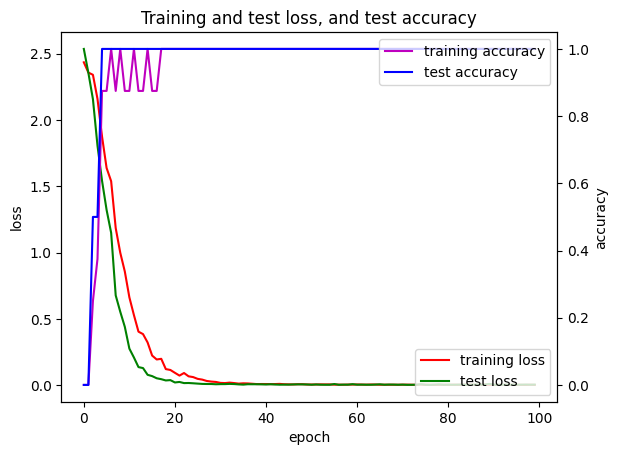

In [ ]:
device = torch.device('cuda:0')
show_graph(path ="./result/3multibranch_test.pt",device = "cuda")

In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
y_true = []
y_pred = []
pointnet_mh = pointnet_mh.to("cpu")
with torch.no_grad():
    for inputs_v,inputs_v2,inputs_v3,labels in valid_loader:
        inputs_v = inputs_v.to(torch.float32)
        inputs_v = inputs_v.squeeze(1).permute(0, 2, 1)
        inputs_v2 = inputs_v2.to(torch.float32)
        inputs_v2 = inputs_v2.squeeze(1).permute(0, 2, 1)
        inputs_v3 = inputs_v3.to(torch.float32)
        inputs_v3 = inputs_v3.squeeze(1).permute(0, 2, 1)
        labels = labels.to(torch.long)
        outputs = pointnet_mh.forward(inputs_v,inputs_v2,inputs_v3)

        outputs = (torch.max(torch.exp(outputs), 1)[1]).data.cpu().numpy()
        y_pred.extend(outputs)
            
        labels = labels.data.cpu().numpy()
        y_true.extend(labels) 
    
classes = ["Unrupture","Rupture"]    
cf_matrix = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(10, 8)) 
sns.heatmap(cf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=classes, yticklabels=classes,annot_kws={"size": 9})
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.title("PointNet Training set Confusion Matrix")
plt.show()

ValueError: too many values to unpack (expected 3)

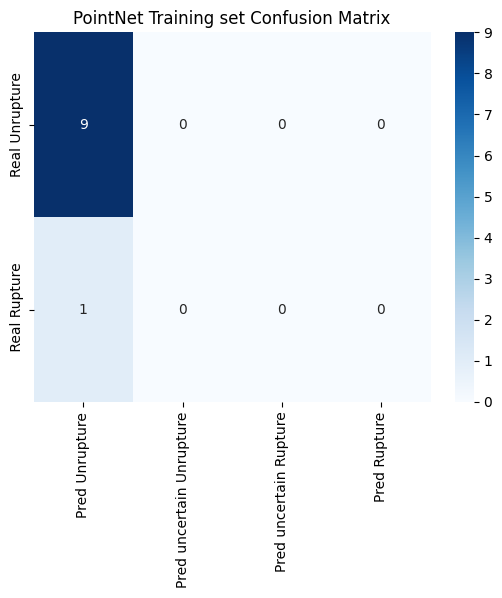

In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import functions as fun

def dim4_cm (real, pred,pred_result):

    cm = [[0,0,0,0],[0,0,0,0]]
    for i in range(len(pred)):
        pos = 0
        if float(pred[i]) < 0.5 and pred_result == 0:
            pos = 1
        elif float(pred[i]) >= 0.5 and pred_result == 0:
            pos = 0
        if float(pred[i]) < 0.5 and pred_result == 1:
            pos = 2
        elif float(pred[i]) >= 0.5 and pred_result == 1:
            pos = 3
            
            
        if real[i] == 0:

            cm[0][pos] += 1
        else:
            cm[1][pos] += 1
    return cm

y_true = []
y_pred = []
y_pred_result = []
pointnet_mh = pointnet_mh.to("cpu")
with torch.no_grad():
    for inputs_v,inputs_v2,labels in valid_loader:
        inputs_v = inputs_v.to(torch.float32)
        inputs_v = inputs_v.squeeze(1).permute(0, 2, 1)
        inputs_v2 = inputs_v2.to(torch.float32)
        inputs_v2 = inputs_v2.squeeze(1).permute(0, 2, 1)
        labels = labels.to(torch.long)
        outputs = pointnet_mh.forward(inputs_v,inputs_v2)
        
        #print(torch.exp(outputs))

        outputs_value = (torch.max(torch.exp(outputs), 1)[0]).data.cpu().numpy()
        outputs_result = (torch.max(torch.exp(outputs), 1)[1]).data.cpu().numpy()
        
        
        #print(outputs)
        y_pred.extend(outputs_value)
        y_pred_result.extend(outputs_result)
            
        labels = labels.data.cpu().numpy()
        y_true.extend(labels) 


cm = dim4_cm(y_true, y_pred,y_pred_result)  
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=["Pred Unrupture","Pred uncertain Unrupture","Pred uncertain Rupture","Pred Rupture"], yticklabels=["Real Unrupture"," Real Rupture"])
#fun.show_pred_cm(cm,y_true)  
# classes = ["Unrupture","Rupture"]    
# cf_matrix = confusion_matrix(y_true, y_pred)
# plt.figure(figsize=(10, 8)) 
# sns.heatmap(cf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=classes, yticklabels=classes,annot_kws={"size": 9})
# plt.xlabel("Predicted Labels")
# plt.ylabel("True Labels")
plt.title("PointNet Training set Confusion Matrix")
plt.show()